In [1]:
import numpy as np
import random
from itertools import permutations
from itertools import product
from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
solvers.options['show_progress'] = False

In [2]:
class soccer_field:
    def __init__(self,positions):
        self.soccer_grid = np.zeros((2,4))
        self.initial_pos = positions
        self.done = False
        if positions[0,1] == 1:
            self.A_has_ball = True
            self.B_has_ball = False
        else:
            self.B_has_ball = True
            self.A_has_ball = False
        
        for i in range(len(positions)):
            if positions[i,0] < 4:
                self.soccer_grid[0,positions[i,0]] = i+1
                col = positions[i,0]
                row = 0
            else:
                self.soccer_grid[1,positions[i,0]-4] = i+1
                col = positions[i,0]-4
                row = 1
                
            if i == 0:
                self.pos_A = [row,col]
            else:
                self.pos_B = [row,col]
        
        self.reward = [0,0]
        
    def print_sg(self,verbose):
        if verbose:
            print(self.soccer_grid)
    
    def initial_state(self):
        if self.A_has_ball:
            init_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            init_pos = [[self.pos_A,self.pos_B],[0,1]]
        return [init_pos]
        
    def index_error(self,r,c,action):
        if action == 1 and c+1<np.shape(self.soccer_grid)[1]:
            nex_pos = [r,c+1]
            move = True
        elif action == 2 and c-1>=0:
            move = True
            nex_pos = [r,c-1]
        elif action == 3 and r+1<np.shape(self.soccer_grid)[0]:
            move = True
            nex_pos = [r+1,c]
        elif action == 4 and r-1>=0:
            move = True
            nex_pos = [r-1,c]
        elif action == 0:
            move = True
            nex_pos = [r,c]
        else:
            move = False
            nex_pos = [r,c]
            
        return [move,nex_pos]
    
    def update_position(self,movements):
        for i in range(len(movements)):
            if movements[i,0] == 1:
                [r,c] = self.pos_A
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                    
                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_A = [r1,c1]
                        self.soccer_grid[r1,c1] = 1
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.A_has_ball:
                        self.A_has_ball = False
                        self.B_has_ball = True
            else:
                [r,c] = self.pos_B
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                

                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_B  = [r1,c1]
                        self.soccer_grid[r1,c1] = 2
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.B_has_ball:
                        self.B_has_ball = False     
                        self.A_has_ball = True
                        
        if self.A_has_ball:
            new_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            new_pos = [[self.pos_A,self.pos_B],[0,1]]
        
        if (self.pos_A[1] == 0 and self.A_has_ball) or (self.pos_B[1] == 0 and self.B_has_ball):
            self.reward = [100,-100]
            self.done = True
        elif (self.pos_A[1] == 3 and self.A_has_ball) or (self.pos_B[1] == 3 and self.B_has_ball):
            self.reward = [-100,100]
            self.done = True
        #print(self.soccer_grid)
        #print(self.A_has_ball)
        #print(self.reward)
        #print(self.done)
        return [self.reward,new_pos,self.done]
        

    

In [3]:
def explore_Greedy(epsilon,v):
    if np.random.rand()<epsilon:
        return np.random.randint(0,5)
    else:
        loc = np.where(v == np.max(v))[0]
        if len(loc)>1:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]
        else:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]

def foe(Q_A_state,Q_B_state, flag):
    obj = matrix([-1.,0.,0.,0.,0.,0.])
    if flag==1:
        m0 = Q_A_state[0:5]
        m1 = Q_A_state[5:10]
        m2 = Q_A_state[10:15]
        m3 = Q_A_state[15:20]
        m4 = Q_A_state[20:]
        #m0 = Q_A_state[[0,5,10,15,20]]
        #m1 = Q_A_state[[1,6,11,16,21]]
        #m2 = Q_A_state[[2,7,12,17,22]]
        #m3 = Q_A_state[[3,8,13,18,23]]
        #m4 = Q_A_state[[4,9,14,19,24]]
        
    else:
        m0 = Q_B_state[0:5]
        m1 = Q_B_state[5:10]
        m2 = Q_B_state[10:15]
        m3 = Q_B_state[15:20]
        m4 = Q_B_state[20:]
        #m0 = Q_B_state[[0,5,10,15,20]]
        #m1 = Q_B_state[[1,6,11,16,21]]
        #m2 = Q_B_state[[2,7,12,17,22]]
        #m3 = Q_B_state[[3,8,13,18,23]]
        #m4 = Q_B_state[[4,9,14,19,24]]
        
    eq_0 = [1.] + [m0[i] for i in range(5)]
    eq_1 = [1.] + [m1[i] for i in range(5)]
    eq_2 = [1.] + [m2[i] for i in range(5)]
    eq_3 = [1.] + [m3[i] for i in range(5)]
    eq_4 = [1.] + [m4[i] for i in range(5)]
    
    eq_00 = [0.,-1., 0., 0., 0., 0.]
    eq_01 = [0., 0., -1., 0., 0., 0.]
    eq_02 = [0., 0., 0., -1., 0., 0.]
    eq_03 = [0., 0., 0., 0., -1., 0.]
    eq_04 = [0., 0., 0., 0., 0., -1.]
    
    eq_s0 = [0., 1., 1., 1., 1., 1.] 
    eq_s1 = [0.,-1.,-1.,-1.,-1.,-1.] 
    
    A=matrix([[eq_0[0],eq_1[0],eq_2[0],eq_3[0],eq_4[0],eq_00[0],eq_01[0],eq_02[0],eq_03[0],eq_04[0],eq_s0[0],eq_s1[0]],
             [eq_0[1],eq_1[1],eq_2[1],eq_3[1],eq_4[1],eq_00[1],eq_01[1],eq_02[1],eq_03[1],eq_04[1],eq_s0[1],eq_s1[1]],
             [eq_0[2],eq_1[2],eq_2[2],eq_3[2],eq_4[2],eq_00[2],eq_01[2],eq_02[2],eq_03[2],eq_04[2],eq_s0[2],eq_s1[2]],
             [eq_0[3],eq_1[3],eq_2[3],eq_3[3],eq_4[3],eq_00[3],eq_01[3],eq_02[3],eq_03[3],eq_04[3],eq_s0[3],eq_s1[3]],
             [eq_0[4],eq_1[4],eq_2[4],eq_3[4],eq_4[4],eq_00[4],eq_01[4],eq_02[4],eq_03[4],eq_04[4],eq_s0[4],eq_s1[4]],
             [eq_0[5],eq_1[5],eq_2[5],eq_3[5],eq_4[5],eq_00[5],eq_01[5],eq_02[5],eq_03[5],eq_04[5],eq_s0[5],eq_s1[5]]])
    
    b=matrix([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,-1.])
    glpksolver = 'cvxopt_glpk'
    sol=solvers.lp(obj,A,b, solver=glpksolver)
    #print(sol['status'])
    result=sol['x']
    V=-result[0]
    return V
    #pi=[]
    #for j in range(5):
        #pi.append(abs(result[j+1]))
    #print(pi)
    #print(np.random.choice(5,1,p=pi))
    
    #if np.random.rand()<epsilon:
       #     st
   #     return np.random.randint(0,5)
   # else:
   #     select = np.random.choice(5,1,p=pi)

   
    
                  

        
#def friend_selection(epsilon,R_Matrix):
    
        
        
#def constraints_maker(Q_a, Q_b):
    
    
#    return constr_matrix
        
#def uCE_selection(jointR_matrix):
    #the input jointR_matrix should be a 5x5 matrix, each cell presents the Q value if player A takes a certain action then B
    
    
    
#    return select

In [4]:
action =[[1, 2, 2], [3, 0, 2], [0, 0, 2], [0, 4, 1], [3, 0, 2], [0, 3, 2], [2, 0, 2], [1, 0, 1], [0, 3, 1], [2, 2, 1], [4, 4, 2], [4, 1, 2], [2, 4, 2], [2, 3, 2], [1, 2, 1], [2, 0, 2], [2, 3, 1], [1, 0, 1], [3, 3, 2], [3, 2, 1], [2, 4, 2], [2, 1, 1], [4, 1, 2], [4, 0, 2], [4, 2, 2], [2, 0, 2], [0, 0, 1], [1, 4, 2], [3, 4, 1], [4, 2, 1], [3, 4, 1], [0, 1, 2], [3, 0, 1], [2, 4, 1], [1, 2, 1], [2, 3, 1], [2, 4, 1], [4, 0, 1], [3, 4, 2], [4, 3, 1], [1, 3, 1], [3, 0, 2], [3, 3, 2], [4, 3, 1], [2, 1, 2], [0, 3, 2], [0, 2, 2], [1, 4, 1], [3, 1, 2], [0, 2, 1], [3, 0, 1], [0, 2, 1], [2, 4, 1], [2, 2, 2], [0, 4, 2], [4, 3, 1], [4, 3, 2], [0, 0, 1], [2, 0, 2], [4, 3, 2], [0, 4, 2], [2, 4, 1], [2, 3, 2], [4, 1, 2], [1, 1, 1], [2, 3, 2], [3, 3, 2], [1, 4, 1], [2, 4, 1], [2, 3, 2], [4, 4, 1], [1, 1, 1], [4, 0, 2], [0, 3, 2], [2, 4, 1], [4, 1, 2], [3, 4, 2], [4, 2, 1], [4, 3, 1], [4, 3, 1], [4, 4, 1], [0, 2, 1], [4, 3, 2], [0, 3, 2], [1, 4, 2], [4, 1, 2], [3, 4, 1], [3, 3, 2], [1, 3, 1], [1, 1, 1], [0, 0, 2], [0, 0, 1], [4, 1, 2], [1, 3, 1], [4, 1, 1], [0, 2, 1], [3, 1, 2], [0, 4, 1], [1, 4, 1], [4, 1, 2], [2, 2, 2], [1, 4, 2], [0, 2, 1], [4, 1, 1], [3, 4, 2], [3, 4, 1], [1, 4, 1], [2, 2, 2], [4, 2, 2], [4, 1, 2], [4, 4, 1], [0, 3, 2], [0, 1, 1], [4, 1, 2], [0, 0, 1], [2, 0, 2], [3, 3, 2], [4, 0, 2], [4, 2, 2], [2, 1, 2], [1, 2, 1], [4, 4, 2], [0, 0, 1], [1, 2, 1], [1, 3, 2], [0, 2, 2], [1, 2, 1], [0, 4, 1], [2, 4, 2], [4, 4, 1], [1, 4, 2], [4, 1, 2], [4, 3, 1], [2, 0, 1], [2, 4, 1], [0, 0, 1], [1, 0, 2], [2, 1, 2], [1, 2, 2], [3, 3, 1], [2, 4, 1], [0, 1, 2], [4, 3, 1], [0, 0, 1], [4, 0, 1], [1, 0, 1], [3, 4, 1], [2, 4, 2], [2, 4, 1], [0, 1, 1], [4, 4, 2], [0, 3, 2], [4, 4, 2], [0, 1, 2], [2, 1, 1], [3, 0, 2], [0, 3, 2], [3, 4, 1], [0, 2, 1], [4, 0, 1], [1, 3, 2], [2, 0, 1], [2, 2, 2], [3, 4, 1], [2, 1, 1], [2, 2, 2], [1, 4, 2], [2, 3, 1], [3, 2, 1], [2, 2, 1], [1, 3, 2], [4, 3, 2], [3, 0, 2], [2, 3, 2], [0, 2, 1], [3, 1, 1], [0, 2, 1], [0, 3, 1], [2, 4, 2], [1, 2, 2], [3, 1, 2], [0, 1, 2], [2, 0, 2], [4, 4, 1], [0, 1, 2], [2, 4, 1], [1, 0, 2], [2, 1, 1], [2, 3, 2], [4, 4, 2], [3, 0, 2], [3, 1, 2], [1, 4, 1], [0, 4, 1], [0, 1, 1], [4, 0, 2], [0, 2, 1], [0, 0, 2], [4, 1, 2], [2, 1, 1], [4, 1, 2], [1, 3, 2], [4, 1, 2], [3, 3, 1], [2, 0, 1], [3, 3, 1], [0, 2, 2], [0, 0, 1], [3, 0, 2], [3, 1, 1], [4, 0, 2], [1, 0, 1], [2, 4, 2], [4, 3, 1], [1, 2, 1], [4, 0, 1], [1, 3, 1], [2, 0, 1], [1, 1, 1], [4, 1, 2], [4, 3, 1], [3, 2, 1], [1, 2, 1], [4, 4, 2], [3, 4, 2], [2, 4, 2], [2, 2, 1], [3, 3, 1], [1, 3, 2], [2, 0, 2], [4, 0, 2], [2, 3, 2], [3, 0, 2], [0, 3, 1], [4, 4, 2], [3, 4, 1], [4, 3, 1], [0, 2, 1], [1, 2, 1], [1, 4, 2], [0, 0, 1], [3, 1, 2], [3, 1, 1], [4, 4, 2], [3, 1, 2], [0, 0, 2], [2, 2, 1], [3, 3, 1], [2, 3, 1], [1, 2, 2], [2, 3, 1], [0, 0, 1], [2, 4, 1], [3, 3, 1], [0, 3, 1], [0, 1, 1], [0, 2, 2], [0, 4, 2], [0, 2, 2], [2, 0, 1], [4, 4, 1], [2, 2, 2], [2, 2, 1], [4, 4, 2], [2, 3, 1], [2, 2, 1], [1, 4, 2], [0, 2, 2], [3, 1, 1], [1, 2, 1], [2, 4, 1], [1, 2, 1], [0, 0, 2], [1, 0, 1], [2, 0, 2], [1, 2, 2], [4, 0, 1], [2, 0, 1], [1, 1, 1], [1, 2, 2], [4, 4, 1], [3, 1, 1], [3, 3, 2], [1, 3, 1], [0, 2, 2], [0, 4, 1], [0, 2, 2], [3, 0, 1], [0, 1, 1], [1, 4, 2], [2, 4, 2], [0, 2, 1], [4, 1, 1], [3, 3, 1], [2, 0, 1], [4, 1, 1], [3, 3, 2], [3, 2, 2], [0, 4, 2], [1, 0, 2], [2, 2, 1], [2, 4, 1], [3, 2, 2], [2, 1, 1], [3, 1, 1], [0, 0, 2], [2, 2, 2], [3, 4, 2], [3, 2, 1], [1, 4, 1], [2, 0, 1], [0, 3, 1], [2, 2, 1], [1, 4, 2], [2, 4, 2], [1, 2, 1], [4, 0, 2], [4, 3, 2], [0, 2, 2], [2, 3, 1], [3, 3, 2], [0, 2, 2], [1, 1, 2], [0, 4, 2], [4, 2, 2], [0, 4, 2], [3, 0, 2], [0, 1, 1], [4, 3, 2], [4, 3, 2], [1, 0, 2], [4, 1, 1], [4, 0, 1], [4, 2, 2], [4, 0, 1], [0, 2, 1], [4, 3, 2], [4, 4, 2], [1, 0, 1], [0, 3, 2], [4, 4, 1], [2, 1, 1], [4, 2, 2], [0, 1, 2], [4, 1, 2], [4, 0, 1], [2, 4, 2], [4, 0, 1], [4, 4, 1], [1, 3, 1], [2, 1, 2], [0, 4, 1], [4, 0, 1], [0, 1, 2], [1, 3, 2], [0, 2, 2], [3, 3, 2], [0, 3, 1], [4, 0, 2], [3, 1, 1], [4, 3, 2], [2, 3, 1], [1, 2, 1], [2, 0, 1], [4, 0, 2], [3, 0, 2], [3, 0, 2], [4, 3, 1], [4, 2, 2], [2, 1, 2], [2, 0, 2], [4, 3, 2], [0, 2, 1], [3, 1, 1], [2, 2, 2], [1, 4, 2], [4, 1, 1], [2, 0, 1], [3, 4, 1], [0, 1, 2], [4, 4, 2], [1, 1, 1], [4, 0, 1], [4, 3, 2], [1, 0, 2], [0, 3, 2], [2, 2, 1], [0, 0, 2], [0, 3, 2], [1, 1, 2], [1, 0, 1], [0, 0, 1], [2, 4, 2], [4, 4, 2], [2, 4, 2], [2, 3, 2], [3, 3, 1], [3, 1, 2], [1, 3, 1], [2, 4, 1], [3, 4, 2], [3, 0, 1], [1, 4, 1], [3, 1, 2], [3, 3, 1], [4, 3, 2], [4, 2, 1], [1, 0, 1], [3, 1, 2], [3, 0, 2], [2, 0, 1], [4, 3, 1], [1, 4, 1], [3, 1, 1], [2, 2, 2], [3, 1, 2], [3, 4, 1], [2, 2, 1], [0, 1, 2], [4, 4, 2], [0, 2, 1], [4, 1, 1], [1, 1, 2], [1, 1, 1], [3, 0, 1], [4, 0, 2], [3, 0, 1], [3, 4, 2], [1, 3, 1], [4, 1, 1], [2, 3, 2], [3, 2, 2], [2, 0, 1], [3, 0, 1], [2, 2, 2], [4, 3, 1], [0, 3, 1], [3, 1, 2], [4, 1, 1], [3, 2, 2], [0, 2, 1], [0, 3, 1], [4, 2, 2], [3, 4, 1], [1, 1, 1], [4, 0, 1], [1, 2, 1], [2, 0, 1], [3, 1, 2], [3, 0, 2], [3, 2, 2], [2, 2, 2], [1, 0, 2], [4, 4, 1], [3, 4, 2], [1, 1, 1], [1, 1, 2], [2, 0, 1], [2, 2, 1], [4, 2, 2], [3, 1, 2], [3, 0, 2], [2, 2, 2], [1, 0, 2], [3, 0, 2], [0, 4, 2], [1, 1, 1], [0, 4, 2], [4, 0, 2], [1, 3, 2], [3, 0, 2], [0, 3, 2], [0, 2, 1], [3, 2, 1], [0, 0, 2], [3, 1, 2], [0, 2, 2], [1, 1, 2], [2, 3, 1], [4, 4, 1], [0, 2, 2], [4, 4, 1], [2, 0, 1], [3, 1, 1], [0, 0, 2], [2, 1, 1], [2, 0, 2], [2, 1, 2], [1, 2, 1], [0, 2, 1], [2, 0, 1], [0, 1, 1], [4, 2, 1], [4, 2, 1], [1, 2, 1], [4, 2, 2], [1, 4, 2], [2, 0, 1], [1, 4, 1], [1, 0, 1]]


In [5]:

max_alpha = 0.9
min_alpha = 0.001
max_eps = 1
min_eps = 0.001
LAMBDA = 0.001
LAMBDA_1 = 0.9

epsilon = max_eps
alpha = max_alpha
gamma = 0.9

r = [0,0]

k = []
for i in range(2):
    for j in range(4):
        k.append([i,j])


perm = permutations(k,2)

all_seq = []

ball = [[0,1],[1,0]]

count = 0
for i in list(perm):
    for j in range(2):
        all_seq.append([list(i),ball[j]])

z = product([0, 1, 2, 3, 4], repeat = 2)

action_list = []
for i in list(z):
    action_list.append(list(i))

Q_A = np.ones((112,25))
Q_B = np.ones((112,25))
step = 0 
done = False
s_a = []

iteration = 500
   
#action = [[3, 3, 2]]
def alpha_reduce_2(step,iteration):
    if step <= 0.7*200000:
        m = (0.15-0.2)/(0.7*200000)
        return m*step+0.2
    else:
        m = (0.001-0.15)/(300000-0.7*300000)
        return m*(step-0.7*300000)+0.15

def alpha_reduce_3(step,limit,alpha_max):
    limit=1000000
    if step <= limit:
        m = (0.001-alpha_max)/(limit)
        return m*step+alpha_max
    else:
        return 0.001
    
    
def alpha_reduce(min_alpha,max_alpha,step):
    return min_alpha + (max_alpha - min_alpha) * math.exp(-LAMBDA_1*step)

#for i in range(iteration):
limit = 1000000
while step < limit:
#for s in range(100):
    s_p = np.array([[2,0],[1,1]])
    soccer = soccer_field(s_p)
    [state_s] = soccer.initial_state()
    new_pos=state_s
    state = all_seq.index(state_s)
    init_state = all_seq.index(state_s)
    
    done = False
    samp = 1
    
    while not done:
        ###
        #action_A = explore_Greedy(epsilon,Q_A[state])
        #action_B = explore_Greedy(epsilon,Q_A[state])
        ###
        first = random.randint(1,2)
        prev = list(Q_A[init_state,])[20]
        action_A = np.random.randint(0,5)
        action_B = np.random.randint(0,5)
        #first = action[step][2]
        #action_A = action[step][0]
        #action_B = action[step][1]
        #V=foe(Q_A[state,],Q_B[state,])
        
        if first == 1:
            move = np.array([[1,action_A],[2,action_B]])
        else:
            move = np.array([[2,action_B],[1,action_A]])
        
        [r,new_pos,done] = soccer.update_position(move) 
        
        state2 = all_seq.index(new_pos)
        a_use = action_list.index([action_A,action_B])
        V_A=foe(Q_A[state2,],Q_B[state2,],1)
        V_B=foe(Q_A[state2,],Q_B[state2,],2)     
        
        if r[0] == 0 or r[1] == 0:
            Q_A[state,a_use] += alpha * ((1-gamma)*r[0] + gamma* V_A - Q_A[state,a_use])
            Q_B[state,a_use] += alpha * ((1-gamma)*r[1] + gamma* -V_B - Q_B[state,a_use])
            new = list(Q_A[init_state,])[20]
            #if np.linalg.norm(np.array(prev)-np.array(new))>0:
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])

            state = state2
        else:
            #game end
            #Q_A[state,] += alpha * ((1-gamma)*r[0] + gamma* V - Q_A[state,])
            #Q_B[state,] += alpha * ((1-gamma)*r[1] + gamma* -V - Q_B[state,])
            Q_A[state,a_use] += alpha * ((1-gamma)*r[0] - Q_A[state,a_use])
            Q_B[state,a_use] += alpha * ((1-gamma)*r[1] - Q_B[state,a_use])     
            new = list(Q_A[init_state,])[20]
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])
            #print(new)
            #st
            #if np.linalg.norm(np.array(prev)-np.array(new))>0:
            #s_a.append([step,np.max(np.abs((np.array(prev)-np.array(new))))])
                
        step += 1
        samp = 2
        #epsilon = eps_reduce_2(step,iteration)
        alpha = alpha_reduce_3(step,limit,max_alpha)
        #alpha = alpha_reduce(min_alpha,max_alpha,step)
        #alpha = alpha_reduce_2(step,iteration)
        ##
        #epsilon = alpha_reduce(min_eps,max_eps,step)
        ##
        #print(step)
s_a_use = np.reshape(s_a,[-1,2])

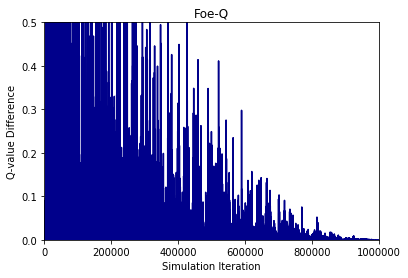

In [7]:
s = np.where(s_a_use[:,1]>0)
k = s_a_use[np.where(s_a_use[:,1]>=0),1][0]
plt.rcParams['agg.path.chunksize'] = 10000
#print(k[1000])
#print(s_a[850000:])
p = np.roll(k, 10000)
plt.plot(s_a_use[:,1],'-',color='darkblue')
plt.ylim([0,0.5])
plt.xlim([0,10e5])
plt.xlabel('Simulation Iteration')
plt.ylabel('Q-value Difference')
plt.title('Foe-Q')
plt.show()
#print(k)

In [8]:
print(Q_A[30,])


[-0.13598927 -0.35446618 10.         -3.04524354 -2.63665108 -10.
 -9.05135411 10.         -7.51144322 -2.76641426 -0.01643207 -0.06828205
 10.         -5.71372206 -2.63923769  3.19823333 -3.33386298 10.
 -2.69614008 -3.81180963  2.19534403  2.19533663 10.         -3.03751702
 -2.63797712]
